In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import MultiplicativeLR
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision

import os
import sys
import shutil
from PIL import Image
from gzip import GzipFile
import gzip
import zipfile

In [2]:
# !pip install enlighten

def pit(it, *pargs, **nargs):
    import enlighten
    global __pit_man__
    try:
        __pit_man__
    except NameError:
        __pit_man__ = enlighten.get_manager()
    man = __pit_man__
    try:
        it_len = len(it)
    except:
        it_len = None
    try:
        ctr = None
        for i, e in enumerate(it):
            if i == 0:
                ctr = man.counter(*pargs, **{**dict(leave = False, total = it_len), **nargs})
            yield e
            ctr.update()
    finally:
        if ctr is not None:
            ctr.close()

In [4]:
df = pd.read_csv('wikiart_csv/style_train.csv',names = ['path','label'])
print(len(df))
df.head()

57025


path  label
0  Impressionism/edgar-degas_landscape-on-the-orn...     12
1         Realism/camille-corot_mantes-cathedral.jpg     21
2  Abstract_Expressionism/gene-davis_untitled-197...      0
3      Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg     24
4  Impressionism/maurice-prendergast_paris-boulev...     12

In [5]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data      = pd.read_csv(csv_file, names = ['path','label'])
        self.root      = root_dir
        self.transform = transform
        self.nb_classes = int(max(self.data['label'])) +1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image name from data
        img_name = self.data.loc[idx][0]
        try: 
            image = Image.open(os.path.join(self.root, img_name))
        except:
            idx+=1
            img_name = self.data.loc[idx][0]
            try: 
                image = Image.open(os.path.join(self.root, img_name))
            except: 
                idx+=1
                img_name = self.data.loc[idx][0]
                image = Image.open(os.path.join(self.root, img_name))
        label = torch.zeros(self.nb_classes)
        label[int(self.data.loc[idx][1])] = 1.0
        # it opens the image of the img_name at the specific idx
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((64,64)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ])
}

train_dataset = CustomDataset('wikiart_csv/style_train.csv', root_dir='wikiart/', transform = data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
 
test_dataset = CustomDataset('wikiart_csv/style_val.csv', root_dir='wikiart/', transform = data_transforms['train'])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

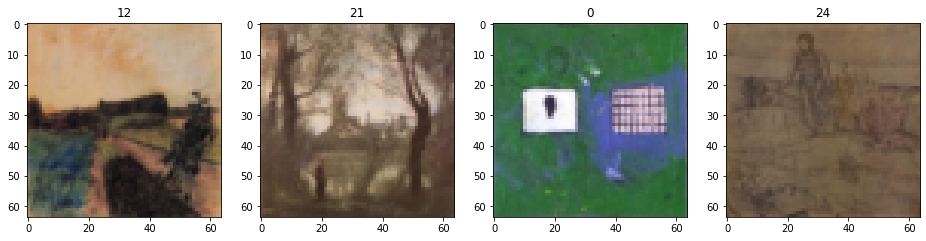

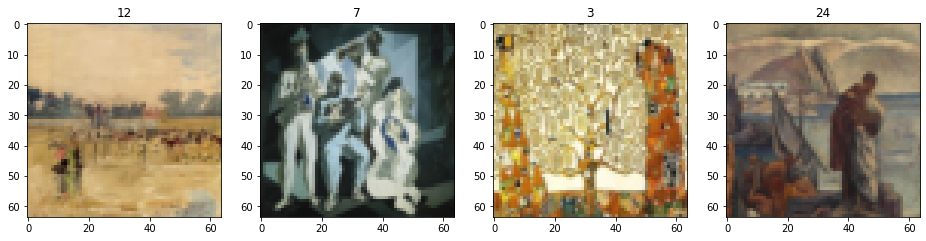

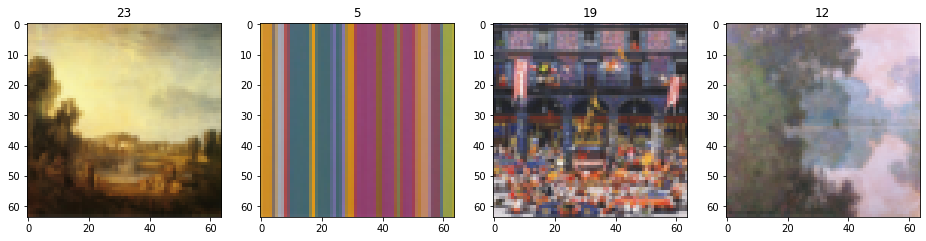

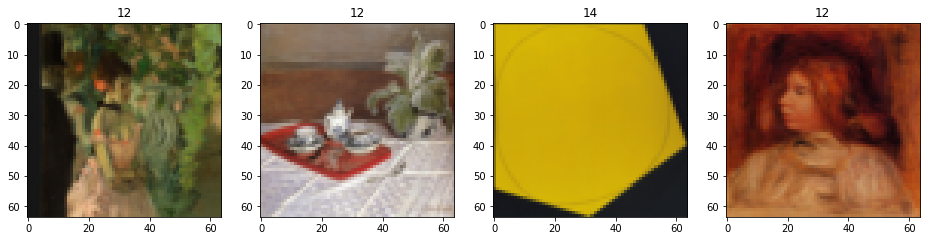

In [7]:
plt.rcParams['figure.figsize'] = (16.0,14.0)

for i in range(0,16,4):
    plt.subplot(1,4,1)
    plt.title(int(torch.argmax(train_dataset[i][1])))
    plt.imshow(train_dataset[i][0].permute(1,2,0))
    plt.subplot(1,4,2)
    plt.title(int(torch.argmax(train_dataset[i+1][1])))
    plt.imshow(train_dataset[i+1][0].permute(1,2,0))
    plt.subplot(1,4,3)
    plt.title(int(torch.argmax(train_dataset[i+2][1])))
    plt.imshow(train_dataset[i+2][0].permute(1,2,0))
    plt.subplot(1,4,4)
    plt.title(int(torch.argmax(train_dataset[i+3][1])))
    plt.imshow(train_dataset[i+3][0].permute(1,2,0))
    plt.show()

In [8]:
alpha = 0.2
size_img = 64
size_noise = 100
nb_classes = max(df['label'])+1
size_in = size_noise + nb_classes
print(size_in)

127


In [9]:
class zNet(nn.Module):
    def __init__(self, size_in):
        super(zNet, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(size_in,1024,4,1,0)  
        self.bn1 = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024,512,4,2,1)  
        self.bn2 = nn.BatchNorm2d(512)
    def forward(self, x):
        x= F.relu(self.bn1(self.deconv1(x)))
        return F.relu(self.bn2(self.deconv2(x)))

In [10]:
class Dec(nn.Module):
    def __init__(self):
        super(Dec, self).__init__()
        
        self.deconv3 = nn.ConvTranspose2d(512,256,4,2,1)  
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256,128,4,2,1)   
        self.bn4 = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128,128,3,1,1)  
        self.bn5 = nn.BatchNorm2d(128)
        self.deconv6 = nn.ConvTranspose2d(128,3,4,2,1)  

    def forward(self, x):
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = F.relu(self.bn5(self.deconv5(x)))
        x = F.sigmoid(self.deconv6(x))
        return x

In [11]:
class Enc(nn.Module):
    def __init__(self):
        super(Enc, self).__init__()
        self.conv1 = nn.Conv2d(3,128,4,stride=2,padding=1)
        self.conv2 = nn.Conv2d(128,128,3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256,4,stride=2,padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,512,4,stride=2,padding=1)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x),alpha)
        x = F.leaky_relu(self.bn2(self.conv2(x)),alpha)
        x = F.leaky_relu(self.bn3(self.conv3(x)),alpha)
        x = F.leaky_relu(self.bn4(self.conv4(x)),alpha)
        return x

In [12]:
class clsNet(nn.Module):
    def __init__(self,size_img,nb_classes):
        super(clsNet, self).__init__()
        self.conv5 = nn.Conv2d(512,1024,4,stride=2,padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.dense6 = nn.Linear(4*size_img*size_img, nb_classes+1)

    def forward(self, x):
        x = F.leaky_relu(self.bn5(self.conv5(x)),alpha)
        return F.sigmoid(self.dense6(x.view(x.size(0), 4*size_img*size_img)))

In [13]:
# inspiré de l'exemple de GAN de pytorch.org

def weights_init(m):
    classname = m.__class__.__name__
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01) 
    elif classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
znet = zNet(size_in).cuda()
znet.apply(weights_init)

decoder = Dec().cuda()
decoder.apply(weights_init)

encoder = Enc().cuda()
encoder.apply(weights_init)

clsnet = clsNet(size_img,nb_classes).cuda()
clsnet.apply(weights_init)

clsNet(
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense6): Linear(in_features=16384, out_features=28, bias=True)
)

In [15]:
learning_rate = 0.001

def lmbda(epoch):
    if epoch == 25:
        return 0.2
    elif epoch == 40:
        return 0.2
    elif epoch == 50:
        return 0.5
    elif epoch == 60:
        return 2
    elif epoch == 70:
        return 0.5
    elif epoch == 80:
        return 0.5
    elif epoch == 100:
        return 2
    elif epoch == 120:
        return 0.5
    elif epoch == 140:
        return 0.5

criterion1 = nn.BCELoss()
criterion2 = nn.BCELoss()
criterion3 = nn.MSELoss(reduction="mean")
criterion4 = nn.BCELoss()

optimizer_znet = torch.optim.RMSprop(znet.parameters(), lr=learning_rate, eps=1e-08, alpha=0.9)
scheduler_znet = MultiplicativeLR(optimizer_znet, lr_lambda=lmbda)

optimizer_dec = torch.optim.RMSprop(decoder.parameters(),lr=learning_rate, eps=1e-08, alpha=0.9)
scheduler_dec = MultiplicativeLR(optimizer_dec, lr_lambda=lmbda)

optimizer_enc = torch.optim.RMSprop(encoder.parameters(),lr=learning_rate, eps=1e-08, alpha=0.9)
scheduler_enc = MultiplicativeLR(optimizer_enc, lr_lambda=lmbda)

optimizer_cls = torch.optim.RMSprop(clsnet.parameters(),lr=learning_rate, eps=1e-08, alpha=0.9)
scheduler_cls = MultiplicativeLR(optimizer_cls, lr_lambda=lmbda)


In [16]:
D_only_loss = []

def train_disc(Enc, clsNet, optimizer_enc, optimizer_cls, train_loader, test_loader, criterion1,
               scheduler_enc, scheduler_cls, n_epoch=5, print_period=5, cuda=True):
        
    for epoch in pit(range(n_epoch)):
        
        for i, data in enumerate(pit(train_loader), 0):
            
            # get the inputs
            imgs_real, labels_real = data
            
            if cuda:
                imgs_real = imgs_real.type(torch.cuda.FloatTensor)
                labels_real = labels_real.type(torch.cuda.LongTensor)
                
            # zero the parameter gradients
            optimizer_enc.zero_grad()
            optimizer_cls.zero_grad()
            
            Y_predict_real = clsNet(Enc(imgs_real))
            labels_true = torch.cat((labels_real,torch.zeros(labels_real.size(0),1).cuda()),1).cuda()
            lossD1 = criterion1(Y_predict_real, labels_true) # loss between predicted by D and true labels
            lossD1.backward()
            
            # entraînement discriminateur
            optimizer_cls.step()
            optimizer_enc.step()
            
            D_only_loss.append(lossD1.item())
            
        if epoch % print_period == print_period-1:

            plt.plot(D_only_loss)
            plt.show()
    
    print('Finished Training')

/anaconda/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda/envs/py38_pytorch/lib/python3.8/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/anaconda/envs/py38_pytorch/lib/python3.8/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


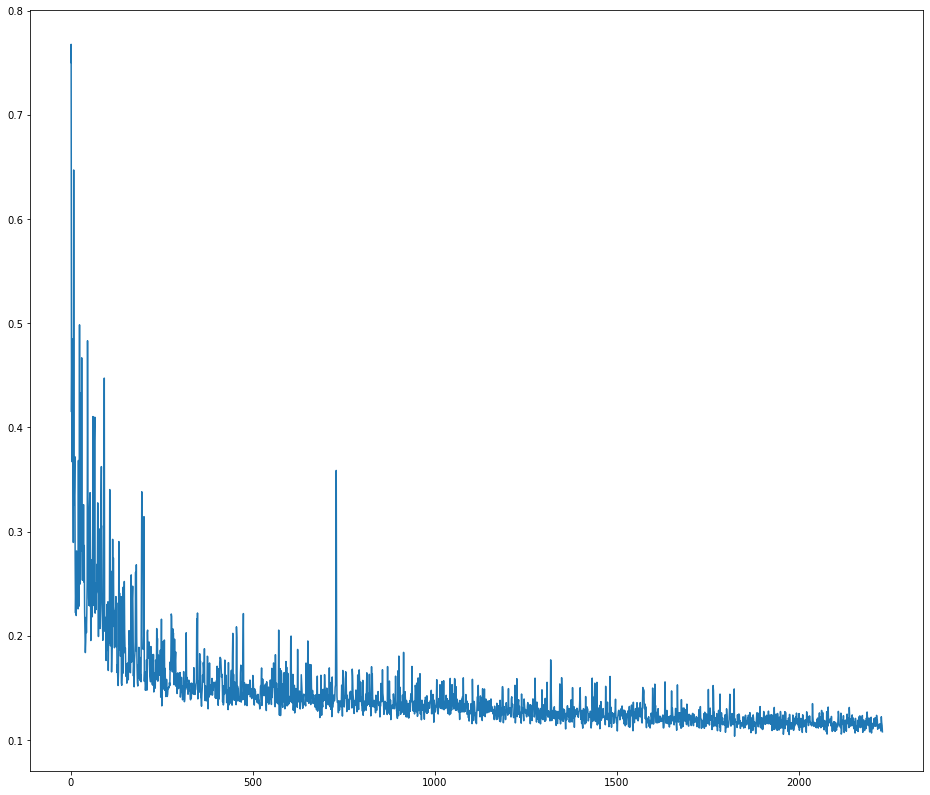

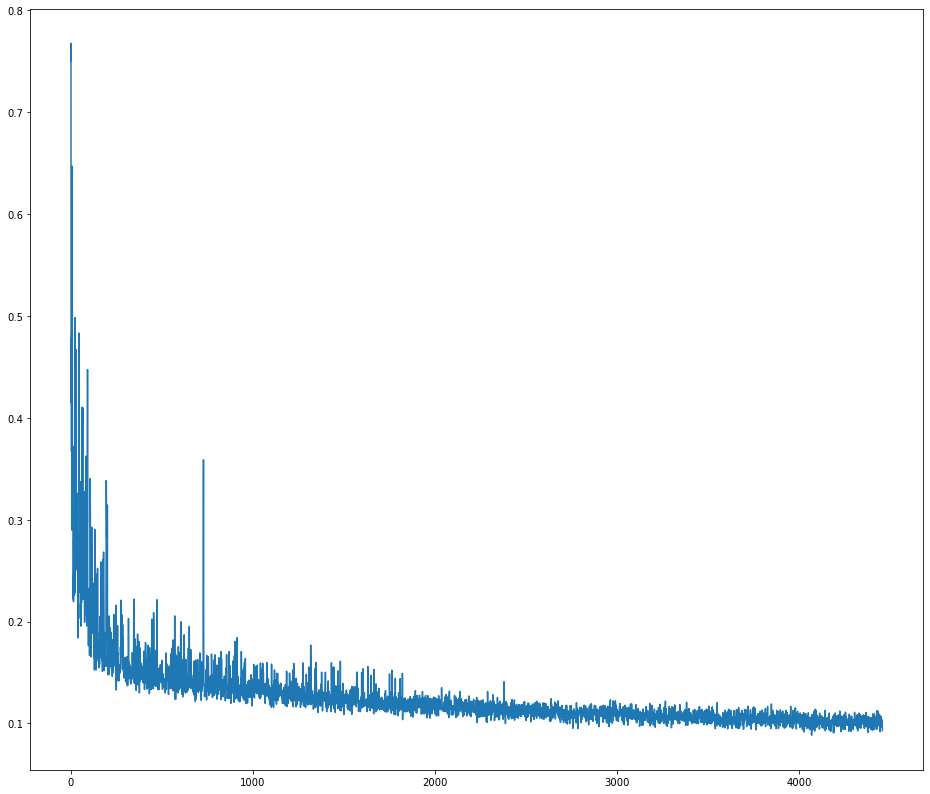

Finished Training


In [17]:
train_disc(encoder, clsnet, optimizer_enc, optimizer_cls, train_loader, test_loader, criterion1, scheduler_enc, scheduler_cls, n_epoch=10)
# training only discriminator

In [ ]:
 plt.rcParams['figure.figsize'] = (16.0,14.0)

def plot_images(zNet, Dec):

    zNet.eval()      
    Dec.eval()
    
    # nb_classes = 27

    for k in range(5):

        plt.subplot(1,5,k+1)

        labels = torch.zeros((1,nb_classes))
        labels[0][k] = 1.
        labels = labels.cuda()

        noise = torch.empty(labels.size(0), size_noise).normal_(mean=0,std=1).cuda()
        inputs_generator = torch.cat((noise,labels),1)
        X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0), inputs_generator.size(1), 1, 1)))
        plt.title(k)
        plt.imshow(X_generated[0].cpu().permute(1,2,0).detach().numpy())

    plt.show()

    for k in range(5,10):

        plt.subplot(1,5,(k-5)+1)

        labels = torch.zeros((1,nb_classes))
        labels[0][k] = 1.
        labels = labels.cuda()

        noise = torch.empty(labels.size(0), size_noise).normal_(mean=0,std=1).cuda()
        inputs_generator = torch.cat((noise,labels),1)
        X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0), inputs_generator.size(1), 1, 1)))
        plt.title(k)
        plt.imshow(X_generated[0].cpu().permute(1,2,0).detach().numpy())

    plt.show()
    
    for k in range(10,15):

        plt.subplot(1,5,(k-10)+1)

        labels = torch.zeros((1,nb_classes))
        labels[0][k] = 1.
        labels = labels.cuda()

        noise = torch.empty(labels.size(0), size_noise).normal_(mean=0,std=1).cuda()
        inputs_generator = torch.cat((noise,labels),1)
        X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0), inputs_generator.size(1), 1, 1)))
        plt.title(k)
        plt.imshow(X_generated[0].cpu().permute(1,2,0).detach().numpy())

    plt.show()
    
    for k in range(15,20):

        plt.subplot(1,5,(k-15)+1)

        labels = torch.zeros((1,nb_classes))
        labels[0][k] = 1.
        labels = labels.cuda()

        noise = torch.empty(labels.size(0), size_noise).normal_(mean=0,std=1).cuda()
        inputs_generator = torch.cat((noise,labels),1)
        X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0), inputs_generator.size(1), 1, 1)))
        plt.title(k)
        plt.imshow(X_generated[0].cpu().permute(1,2,0).detach().numpy())

    plt.show()
    
    for k in range(20,25):

        plt.subplot(1,5,(k-20)+1)

        labels = torch.zeros((1,nb_classes))
        labels[0][k] = 1.
        labels = labels.cuda()

        noise = torch.empty(labels.size(0), size_noise).normal_(mean=0,std=1).cuda()
        inputs_generator = torch.cat((noise,labels),1)
        X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0), inputs_generator.size(1), 1, 1)))
        plt.title(k)
        plt.imshow(X_generated[0].cpu().permute(1,2,0).detach().numpy())

    plt.show()
    
    for k in range(25,27):

        plt.subplot(1,2,(k-25)+1)

        labels = torch.zeros((1,nb_classes))
        labels[0][k] = 1.
        labels = labels.cuda()

        noise = torch.empty(labels.size(0), size_noise).normal_(mean=0,std=1).cuda()
        inputs_generator = torch.cat((noise,labels),1)
        X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0), inputs_generator.size(1), 1, 1)))
        plt.title(k)
        plt.imshow(X_generated[0].cpu().permute(1,2,0).detach().numpy())

    plt.show()

    zNet.train()      
    Dec.train()

In [19]:
G_loss = []
D_loss = []

def train(zNet, Dec, Enc, clsNet, optimizer_znet, optimizer_dec, optimizer_enc, optimizer_cls,
          train_loader, test_loader, criterion1, criterion2, criterion3, criterion4,
          scheduler_znet, scheduler_dec, scheduler_enc, scheduler_cls, n_epoch=5, print_period=5, cuda=True):
        
    for epoch in pit(range(n_epoch)):
        
        for i, data in enumerate(pit(train_loader), 0):
            
            # get the inputs
            imgs_real, labels_real = data
            
            # create labels for fake class
            labels_fake = torch.cat((torch.zeros(labels_real.shape),torch.ones(labels_real.size(0),1)),1).cuda()
            
            if cuda:
                imgs_real = imgs_real.type(torch.cuda.FloatTensor)
                labels_real = labels_real.type(torch.cuda.LongTensor)
                
            # zero the parameter gradients
            optimizer_znet.zero_grad()
            optimizer_dec.zero_grad()
            optimizer_enc.zero_grad()
            optimizer_cls.zero_grad()
            
            # creating input for generator
            noise = torch.empty(labels_real.size(0), size_noise).normal_(mean=0,std=1).cuda() #Z
            inputs_generator = torch.cat((noise,labels_real),1) #Z,Y_k
            
            Y_predict_real = clsNet(Enc(imgs_real)) #Y
            labels_true = torch.cat((labels_real,torch.zeros(labels_real.size(0),1).cuda()),1).cuda()
            
            X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0),inputs_generator.size(1),1,1))) #Xchap
            Y_predict_generated = clsNet(Enc(X_generated.detach())) #Ychap
            
            # loss du discriminateur sur les images réelles + les images générées
            lossD1 = criterion1(Y_predict_real, labels_true) # loss between predicted by D and true labels
            lossD2 = criterion2(Y_predict_generated, labels_fake) # loss between generated by G and labels of fake class
            lossD = lossD1 + lossD2
            lossD.backward()
            
            # entraînement discriminateur
            optimizer_cls.step()
            optimizer_enc.step()
            
            # zero the parameter gradients
            optimizer_znet.zero_grad()
            optimizer_dec.zero_grad()
            optimizer_enc.zero_grad()
            optimizer_cls.zero_grad()
            
            # creating input for generator
            noise = torch.empty(labels_real.size(0), size_noise).normal_(mean=0,std=1).cuda() #Z
            inputs_generator = torch.cat((noise,labels_real),1) #Z,Y_k
            
            Y_predict_real = clsNet(Enc(imgs_real)) #Y
            labels_true = torch.cat((labels_real,torch.zeros(labels_real.size(0),1).cuda()),1).cuda()
            
            X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0),inputs_generator.size(1),1,1))) #Xchap
            Y_predict_generated = clsNet(Enc(X_generated)) #Ychap
            
            # loss du générateur sur les images générées + la reconstruction L2 
            lossG1 = criterion4(Y_predict_generated, labels_true)
            lossG2 = criterion3(imgs_real, Dec(Enc(imgs_real)))
            lossG = lossG2 + lossG1
            lossG.backward()

            # entraînement du générateur
            optimizer_dec.step()
            optimizer_znet.step()
            
            G_loss.append(lossG.item())
            D_loss.append(lossD.item())
            
        torch.save(zNet, 'zNet_temp_model_styles.pt')
        torch.save(Dec, 'Dec_temp_model_styles.pt')
        torch.save(Enc, 'Enc_temp_model_styles.pt')
        torch.save(clsNet, 'clsNet_temp_model_styles.pt')
        
        if epoch % print_period == print_period-1:
            
            torch.save(zNet, 'zNet_'+ str(epoch +1) +'_model_styles.pt')
            torch.save(Dec, 'Dec_'+ str(epoch+1) +'_model_styles.pt')
            torch.save(Enc, 'Enc_'+ str(epoch+1) +'_model_styles.pt')
            torch.save(clsNet, 'clsNet_'+ str(epoch+1) +'_model_styles.pt')
            
            plt.plot(G_loss)
            plt.show()
            plt.plot(D_loss)
            plt.show()
            
            plot_images(zNet, Dec)
            
        if epoch in [25,40,50,60,70,80,100,120,140]:
            scheduler_znet.step()
            scheduler_dec.step()
            scheduler_enc.step()
            scheduler_cls.step()
    
    print('Finished Training')

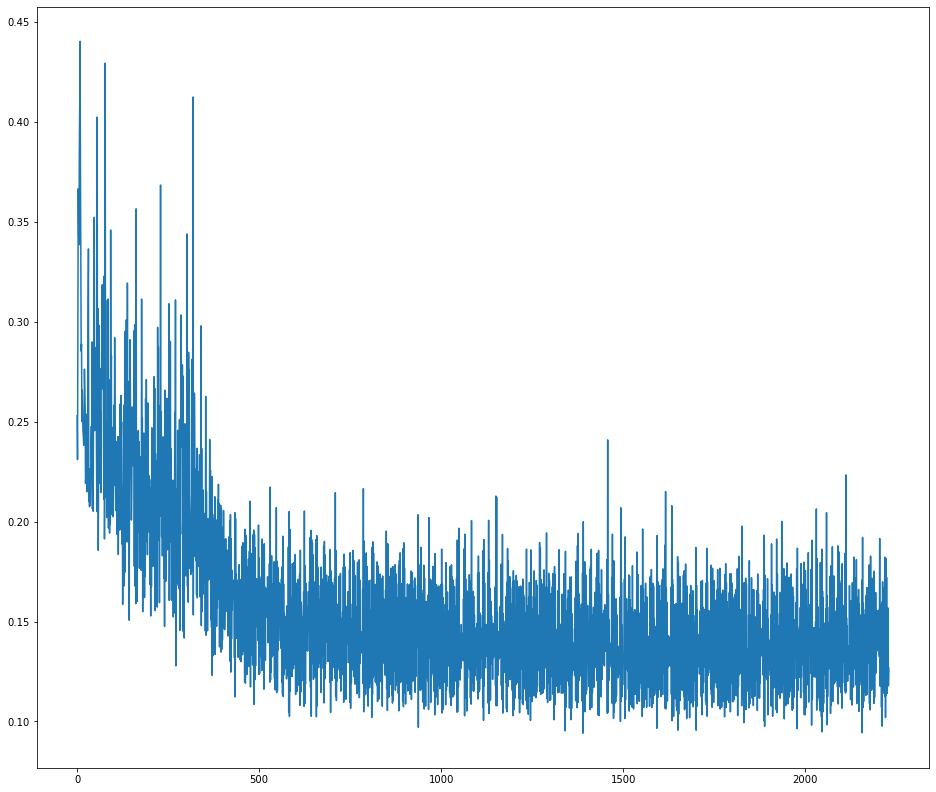

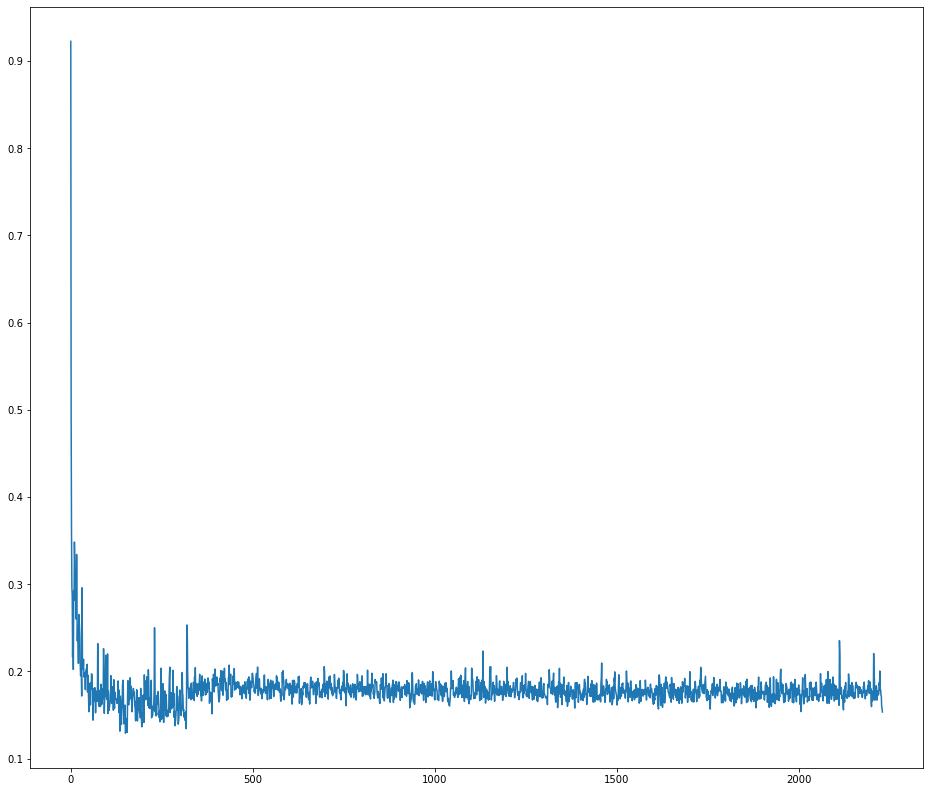

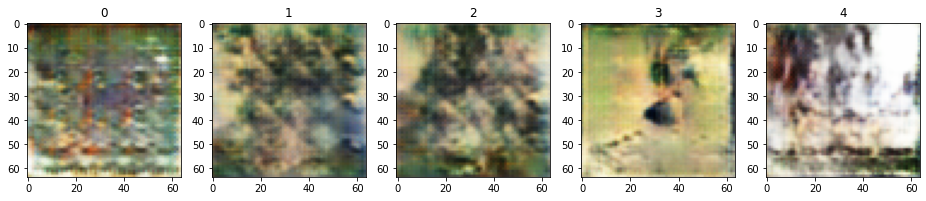

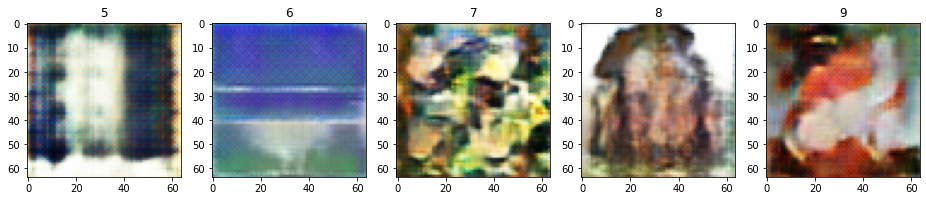

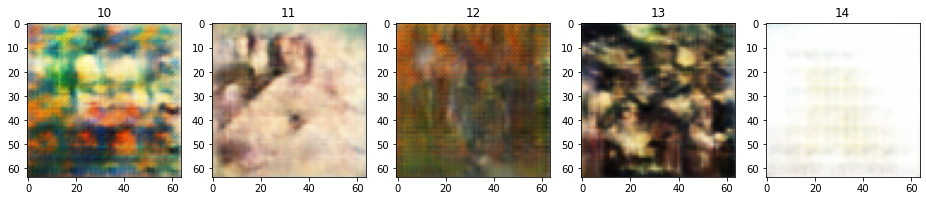

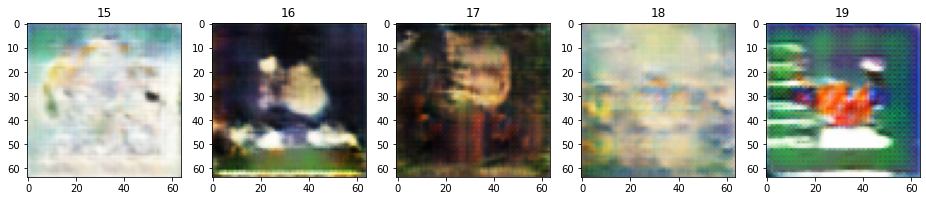

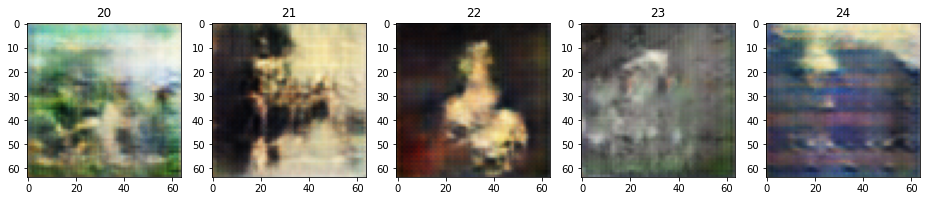

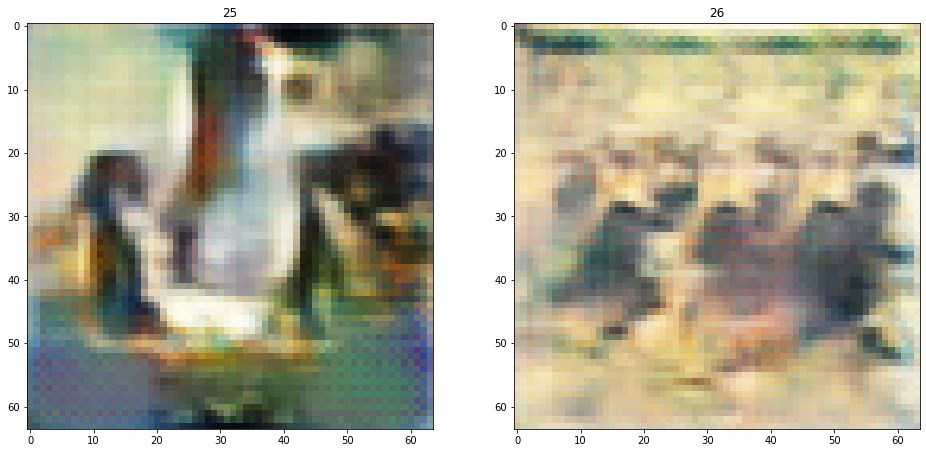

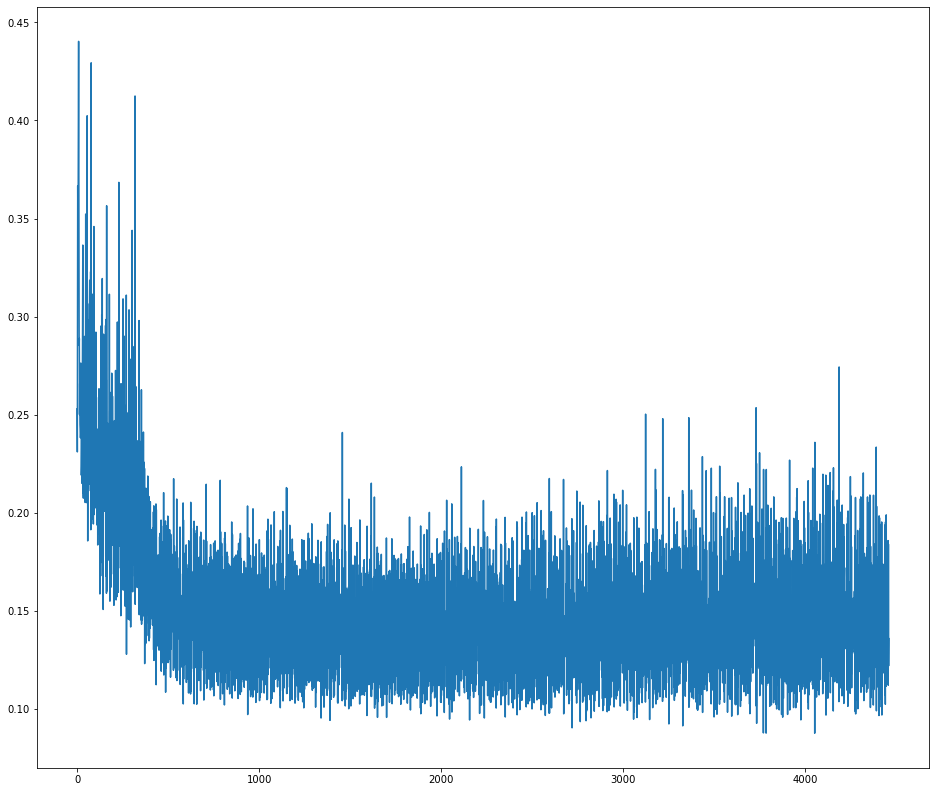

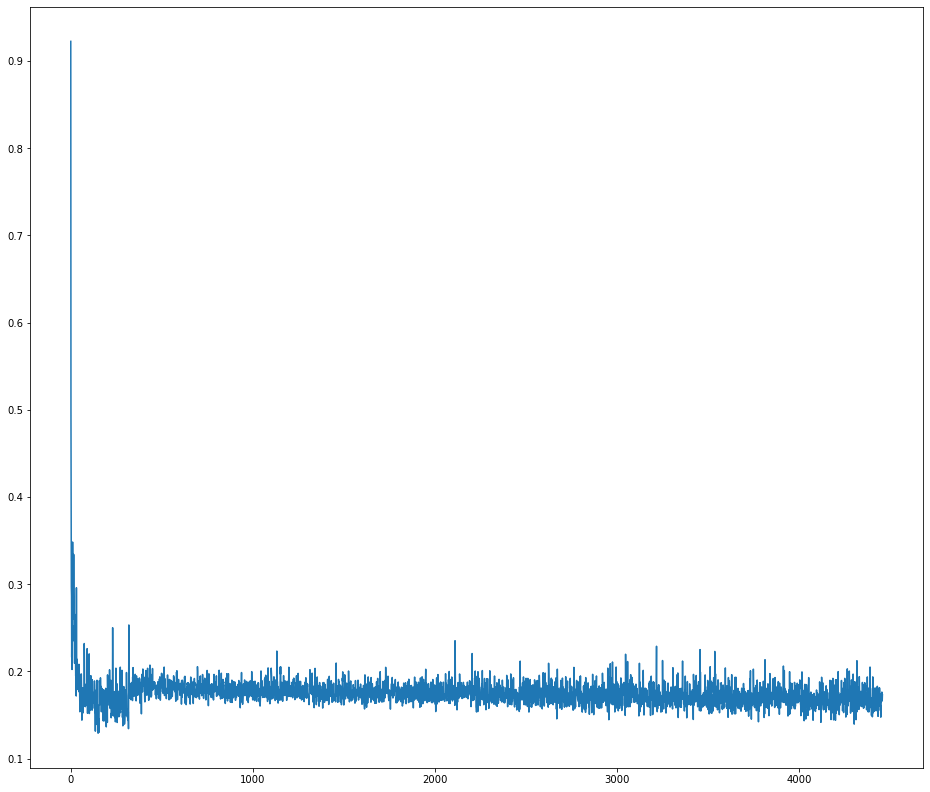

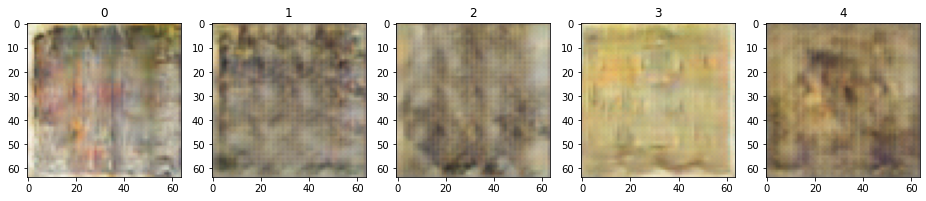

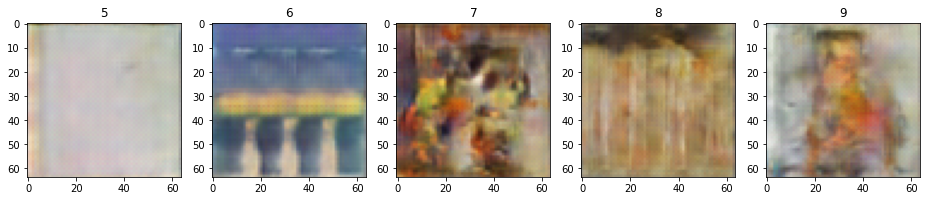

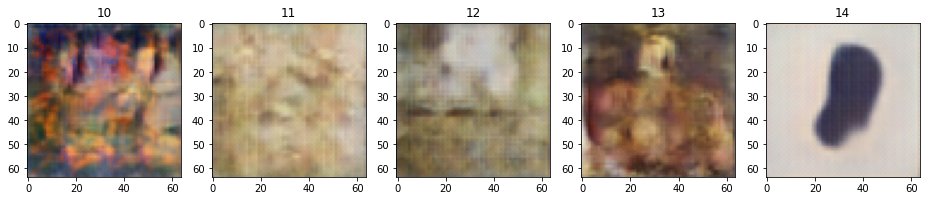

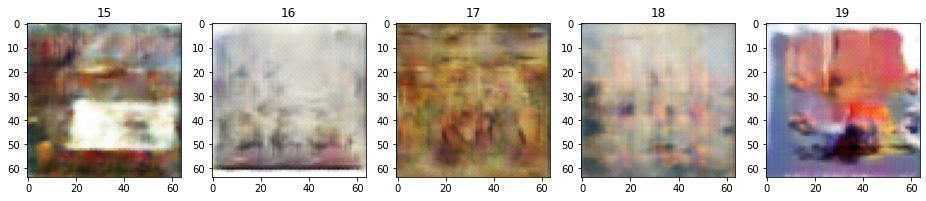

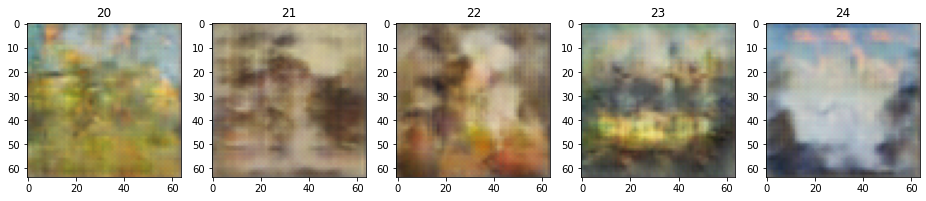

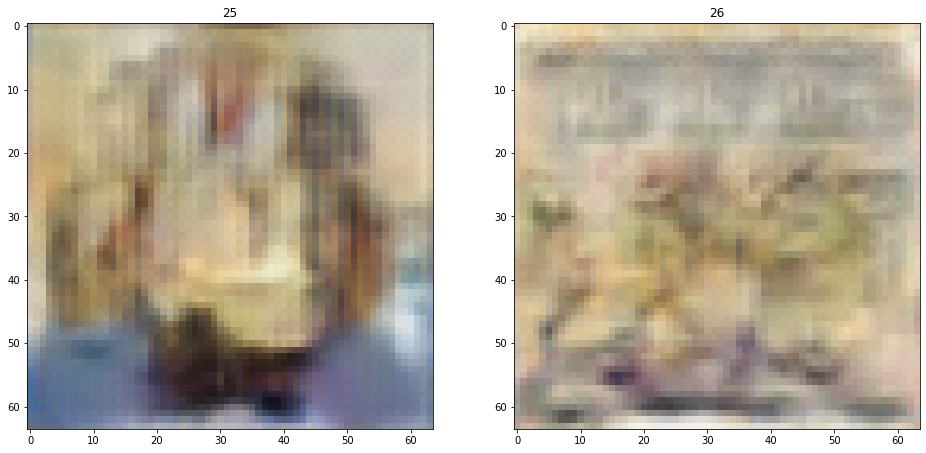

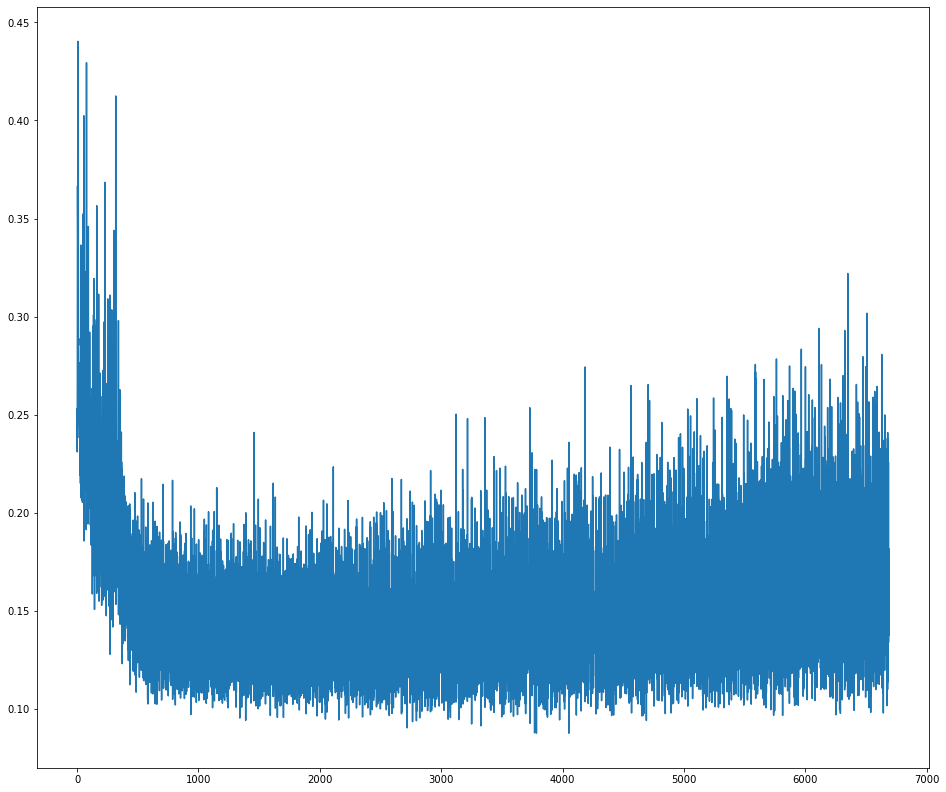

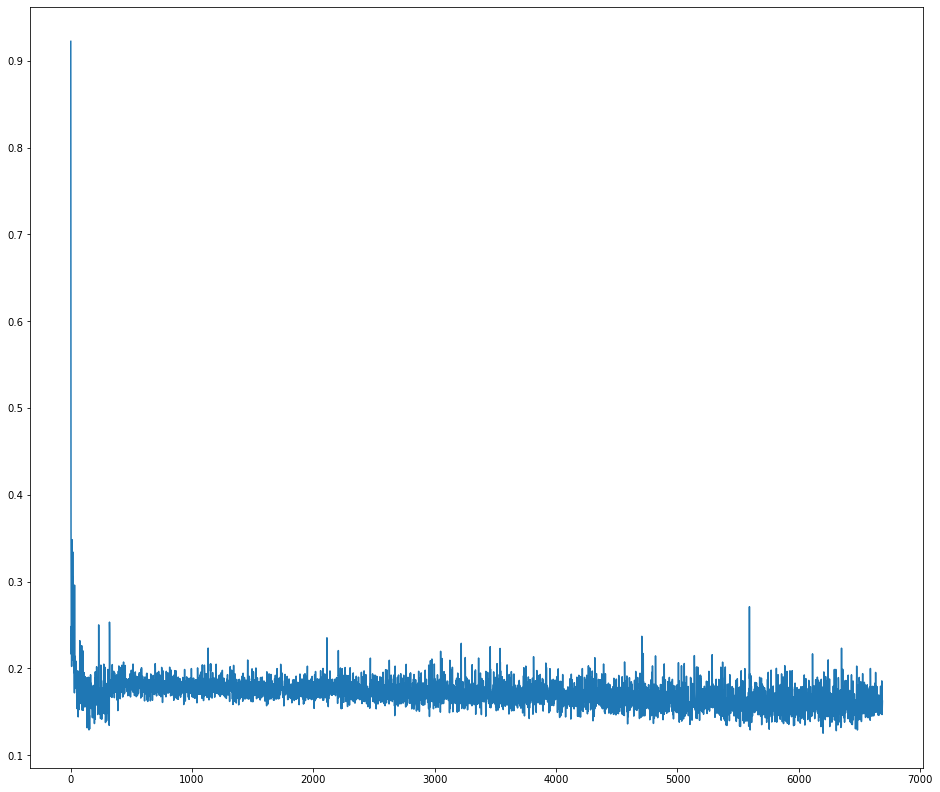

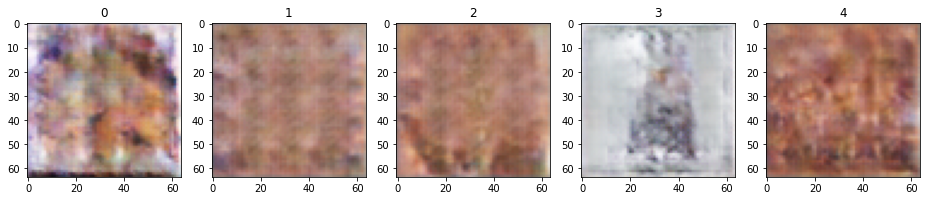

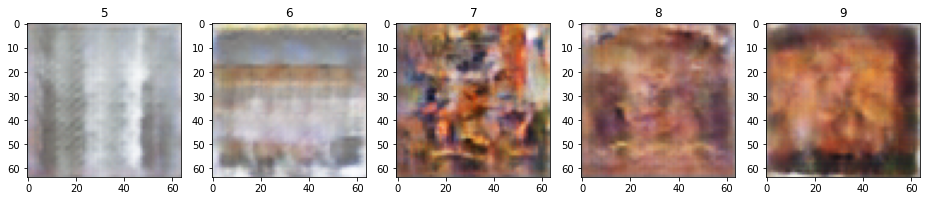

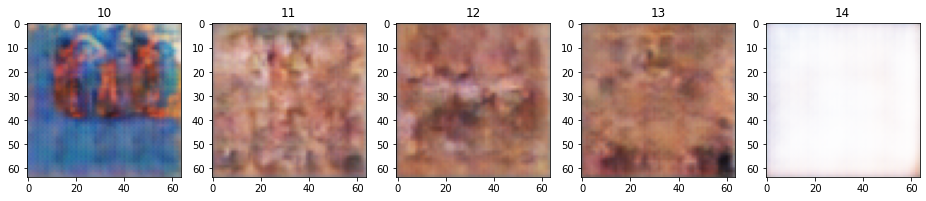

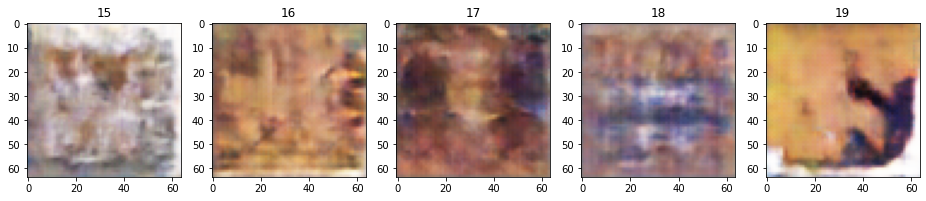

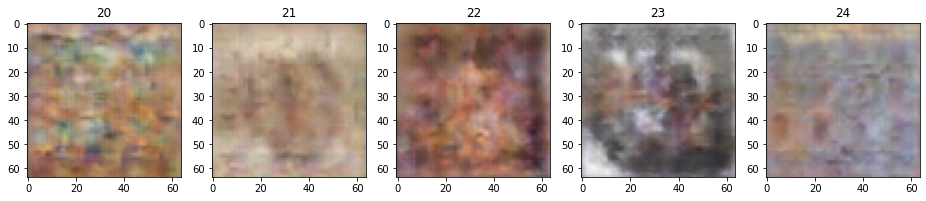

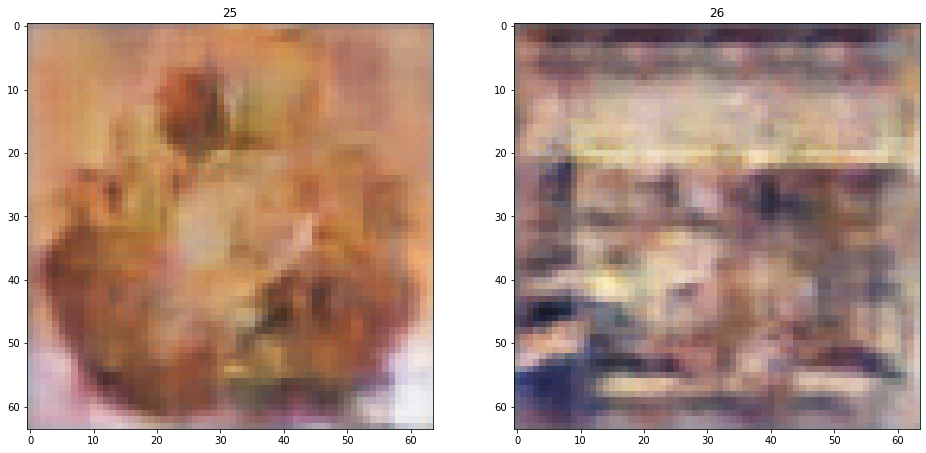

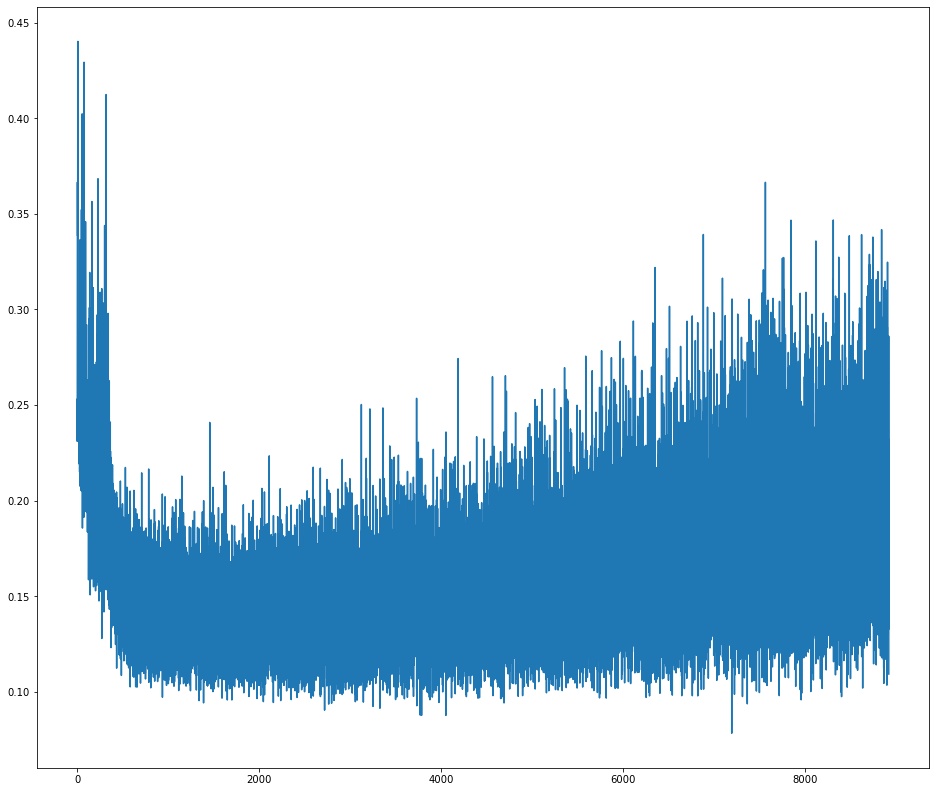

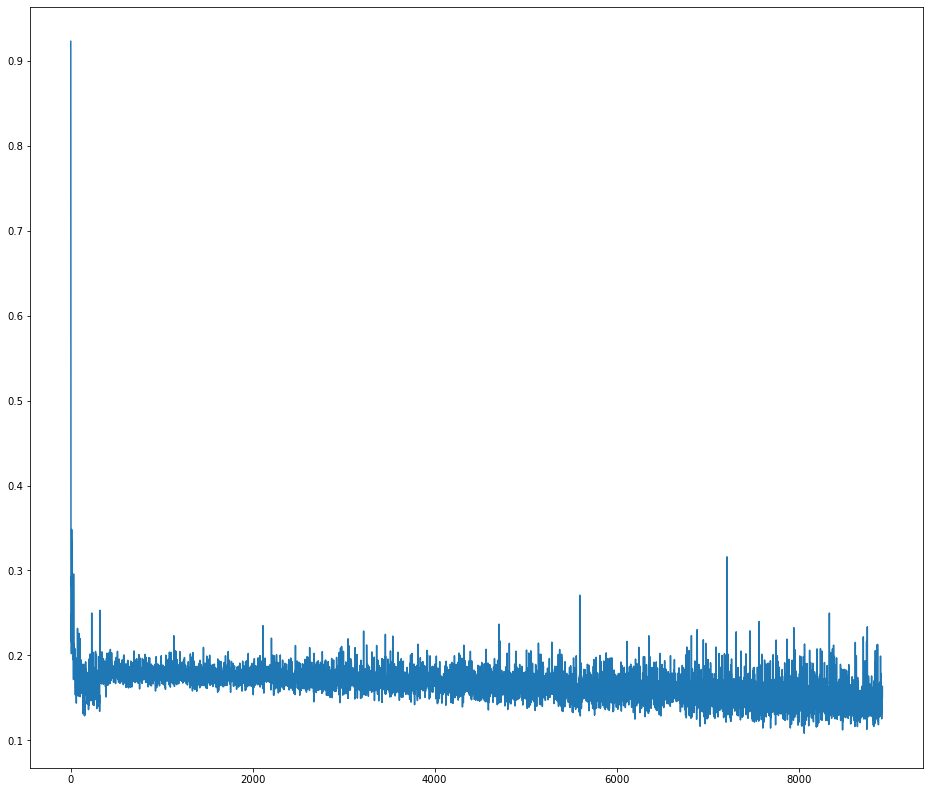

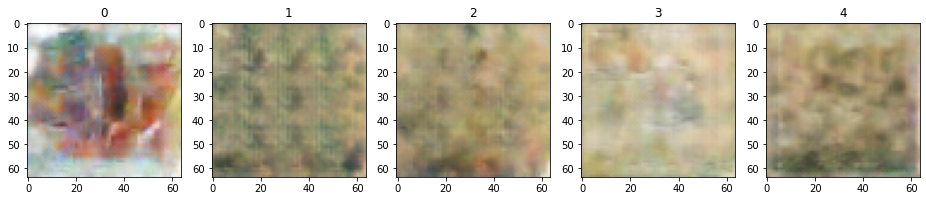

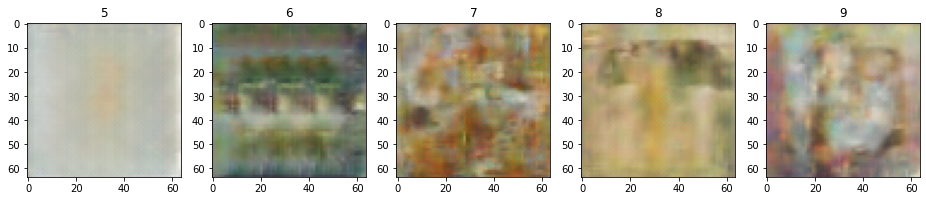

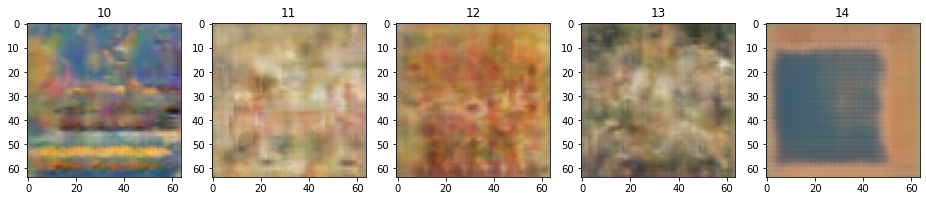

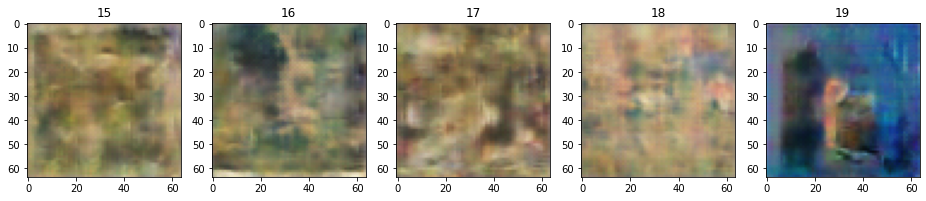

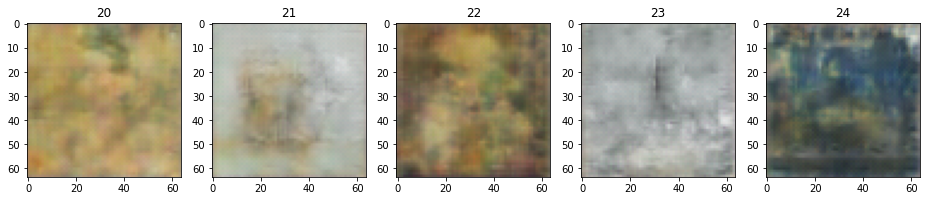

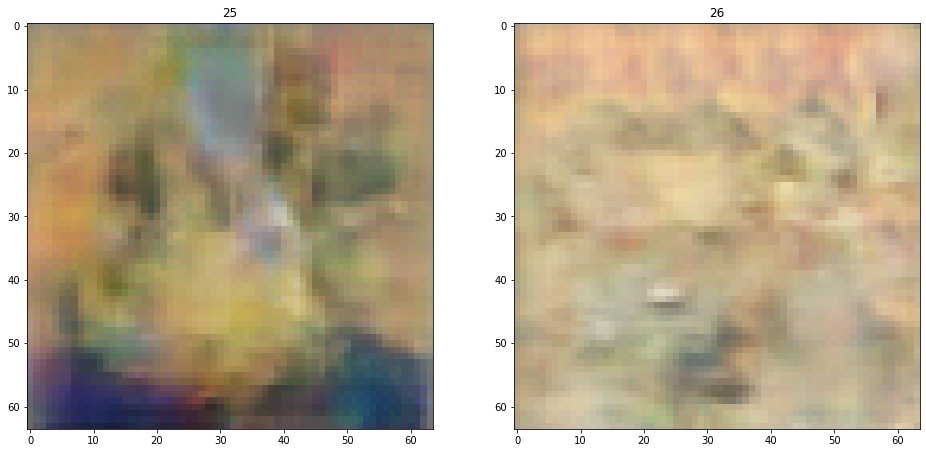

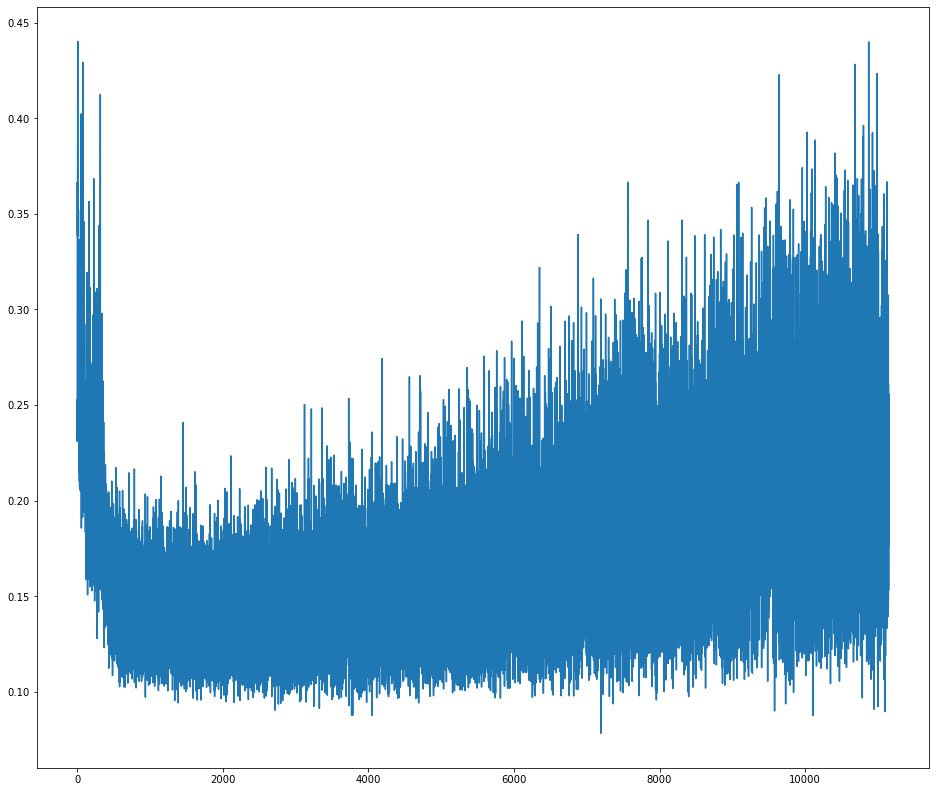

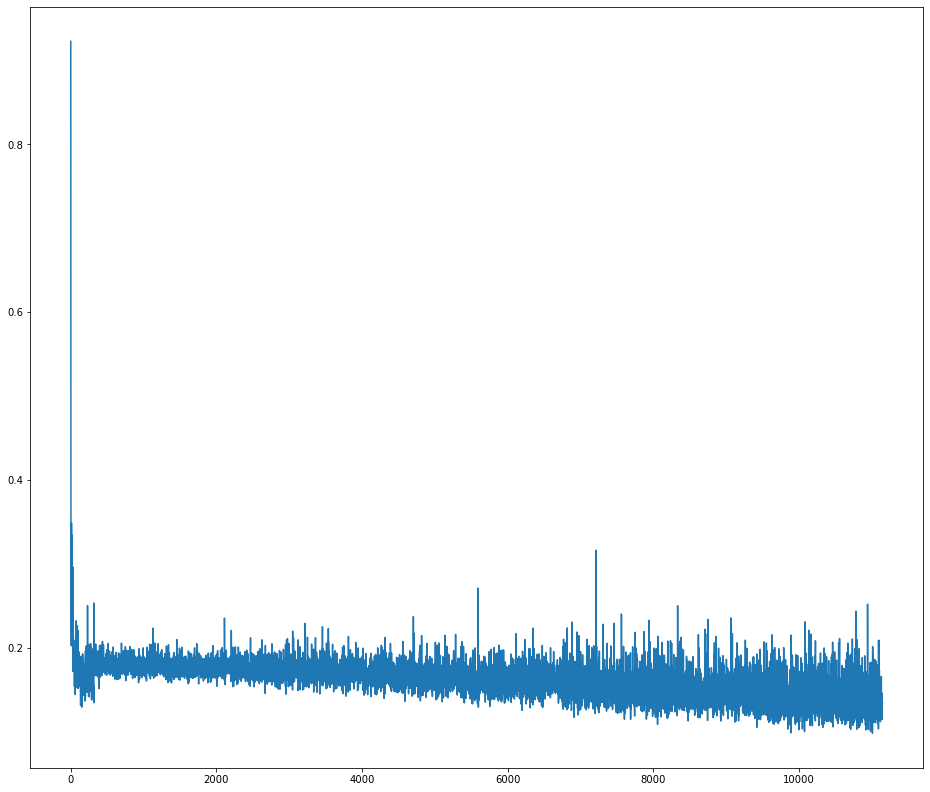

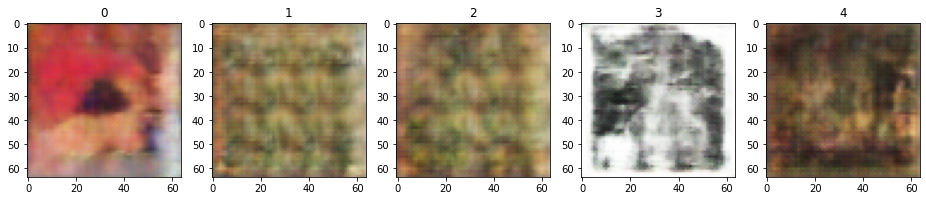

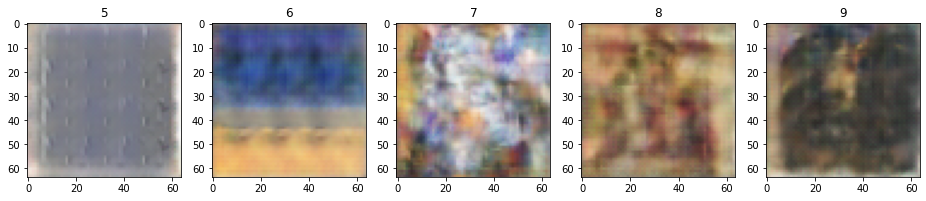

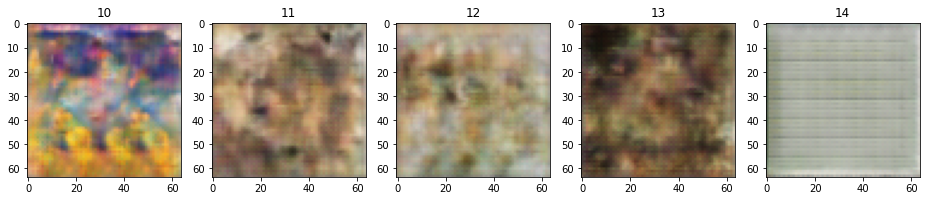

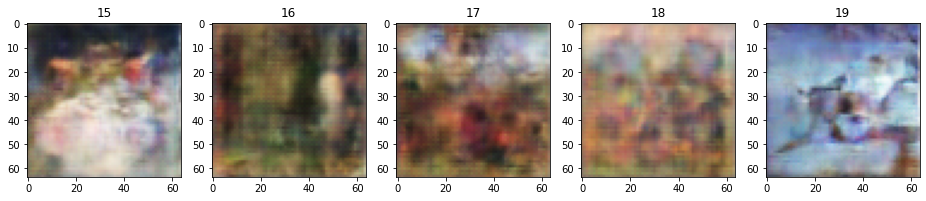

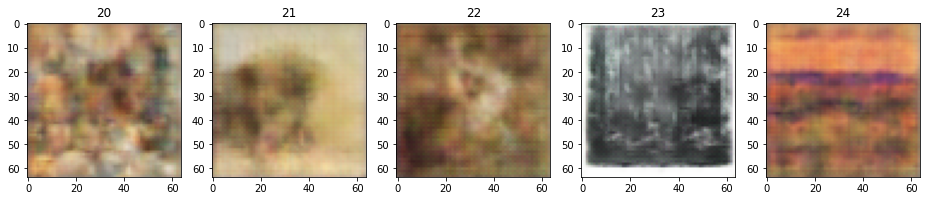

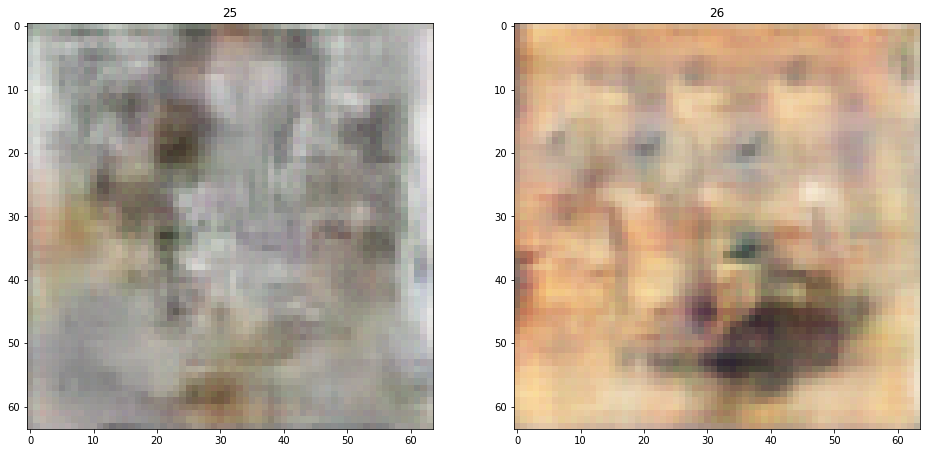

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [20]:
train(znet, decoder, encoder, clsnet, optimizer_znet, optimizer_dec, optimizer_enc, optimizer_cls, train_loader, test_loader, criterion1, criterion2, criterion3, criterion4, scheduler_znet, scheduler_dec, scheduler_enc, scheduler_cls, n_epoch=80)
# training discriminator and generator

In [ ]:
nb_show = 5
for k in range(nb_show):
    plot_images(znet,decoder)

In [21]:
def lmbda_function(epoch):
    epoch_suite = epoch +24
    if epoch_suite == 25:
        return 0.2
    elif epoch_suite == 40:
        return 0.2
    elif epoch_suite == 50:
        return 0.5
    elif epoch_suite == 60:
        return 2
    elif epoch_suite == 70:
        return 0.5
    elif epoch_suite == 80:
        return 0.5
    elif epoch_suite == 100:
        return 2
    elif epoch_suite == 120:
        return 0.5
    elif epoch_suite == 140:
        return 0.5
    else:
        return 1.0
    
lmbda = lambda epoch : lmbda_function(epoch)
scheduler_znet = MultiplicativeLR(optimizer_znet, lr_lambda=lmbda)
scheduler_dec = MultiplicativeLR(optimizer_dec, lr_lambda=lmbda)
scheduler_enc = MultiplicativeLR(optimizer_enc, lr_lambda=lmbda)
scheduler_cls = MultiplicativeLR(optimizer_cls, lr_lambda=lmbda)

def train_restart(zNet, Dec, Enc, clsNet, optimizer_znet, optimizer_dec, optimizer_enc, optimizer_cls,
          train_loader, test_loader, criterion1, criterion2, criterion3, criterion4,
          scheduler_znet, scheduler_dec, scheduler_enc, scheduler_cls, n_epoch=5, print_period=5, cuda=True):
        
    for epoch in pit(range(25, n_epoch)):
        
        for i, data in enumerate(pit(train_loader), 0):
            
            # get the inputs
            imgs_real, labels_real = data
            
            # create labels for fake class
            labels_fake = torch.cat((torch.zeros(labels_real.shape),torch.ones(labels_real.size(0),1)),1).cuda()
            
            if cuda:
                imgs_real = imgs_real.type(torch.cuda.FloatTensor)
                labels_real = labels_real.type(torch.cuda.LongTensor)
                
            # zero the parameter gradients
            optimizer_znet.zero_grad()
            optimizer_dec.zero_grad()
            optimizer_enc.zero_grad()
            optimizer_cls.zero_grad()
            
            # creating input for generator
            noise = torch.empty(labels_real.size(0), size_noise).normal_(mean=0,std=1).cuda() #Z
            inputs_generator = torch.cat((noise,labels_real),1) #Z,Y_k
            
            Y_predict_real = clsNet(Enc(imgs_real)) #Y
            labels_true = torch.cat((labels_real,torch.zeros(labels_real.size(0),1).cuda()),1).cuda()
            
            X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0),inputs_generator.size(1),1,1))) #Xchap
            Y_predict_generated = clsNet(Enc(X_generated.detach())) #Ychap
            
            # loss du discriminateur sur les images réelles + les images générées
            lossD1 = criterion1(Y_predict_real, labels_true) # loss between predicted by D and true labels
            lossD2 = criterion2(Y_predict_generated, labels_fake) # loss between generated by G and labels of fake class
            lossD = lossD1 + lossD2
            lossD.backward()
            
            # entraînement discriminateur
            optimizer_cls.step()
            optimizer_enc.step()
            
            # zero the parameter gradients
            optimizer_znet.zero_grad()
            optimizer_dec.zero_grad()
            optimizer_enc.zero_grad()
            optimizer_cls.zero_grad()
            
            # creating input for generator
            noise = torch.empty(labels_real.size(0), size_noise).normal_(mean=0,std=1).cuda() #Z
            inputs_generator = torch.cat((noise,labels_real),1) #Z,Y_k
            
            Y_predict_real = clsNet(Enc(imgs_real)) #Y
            labels_true = torch.cat((labels_real,torch.zeros(labels_real.size(0),1).cuda()),1).cuda()
            
            X_generated = Dec(zNet(inputs_generator.view(inputs_generator.size(0),inputs_generator.size(1),1,1))) #Xchap
            Y_predict_generated = clsNet(Enc(X_generated)) #Ychap
            
            # loss du générateur sur les images générées + la reconstruction L2 
            lossG1 = criterion4(Y_predict_generated, labels_true)
            lossG2 = criterion3(imgs_real, Dec(Enc(imgs_real)))
            lossG = lossG2 + lossG1
            lossG.backward()

            # entraînement du générateur
            optimizer_dec.step()
            optimizer_znet.step()
            
            G_loss.append(lossG.item())
            D_loss.append(lossD.item()) 
            
        if epoch % print_period == print_period-1:
            torch.save(zNet, 'zNet_'+ str(epoch +1) +'_model_styles.pt')
            torch.save(Dec, 'Dec_'+ str(epoch+1) +'_model_styles.pt')
            torch.save(Enc, 'Enc_'+ str(epoch+1) +'_model_styles.pt')
            torch.save(clsNet, 'clsNet_'+ str(epoch+1) +'_model_styles.pt')                             
            plt.plot(G_loss)
            plt.show()
            plt.plot(D_loss)
            plt.show()
            
            plot_images(zNet, Dec)
            
        scheduler_znet.step()
        scheduler_dec.step()
        scheduler_enc.step()
        scheduler_cls.step()
    
    print('Finished Training')

In [ ]:
train_restart(znet, decoder, encoder, clsnet, optimizer_znet, optimizer_dec, optimizer_enc, optimizer_cls, train_loader, test_loader, criterion1, criterion2, criterion3, criterion4, scheduler_znet, scheduler_dec, scheduler_enc, scheduler_cls, n_epoch=80)

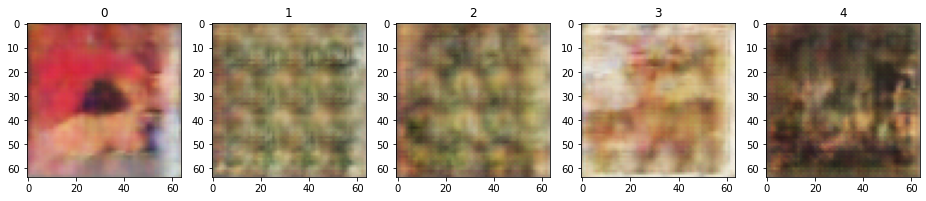

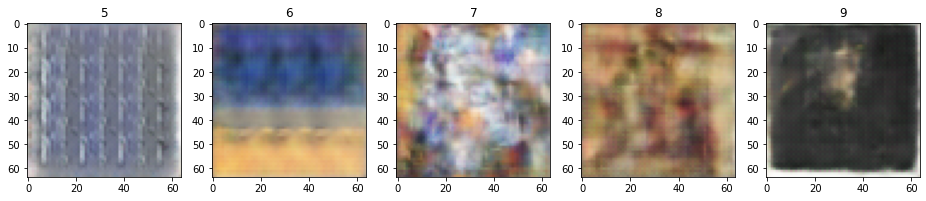

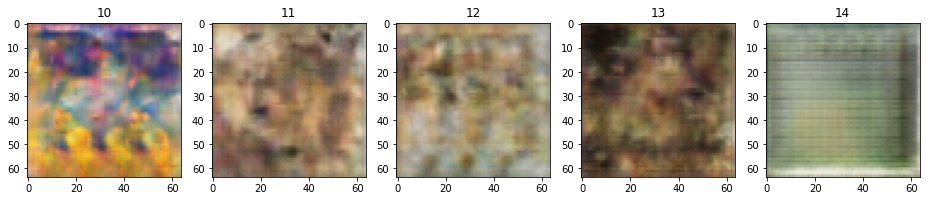

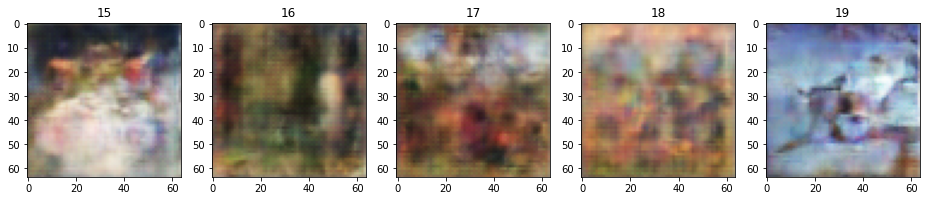

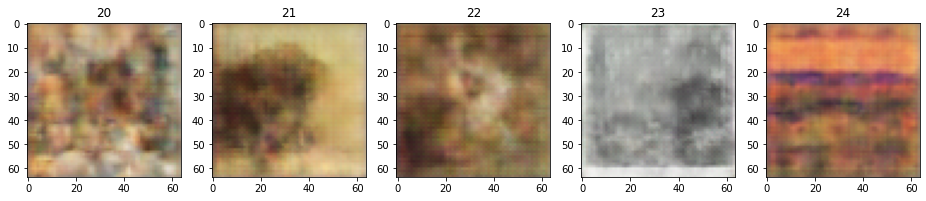

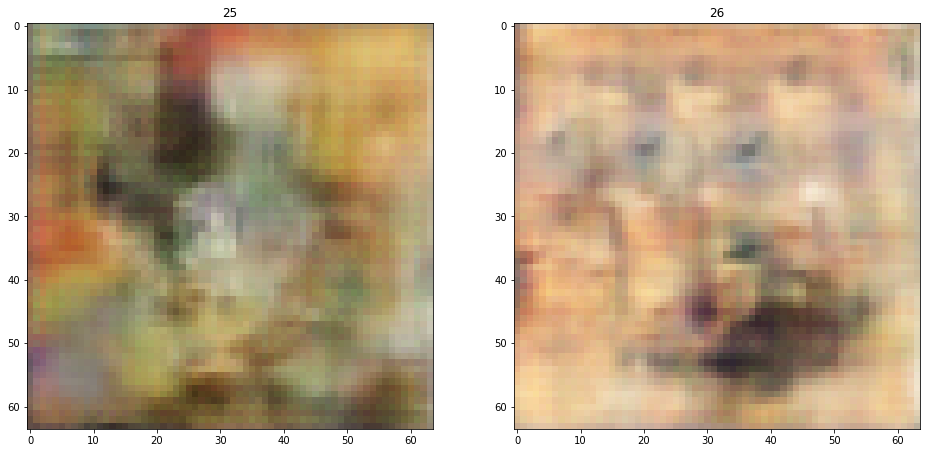

In [35]:
znet= torch.load('zNet_25_model_styles.pt')
decoder = torch.load('Dec_25_model_styles.pt')
plot_images(znet, decoder)

In [ ]:
def accuracy(zNet,Dec,Enc,clsNet,test_loader, cuda=True):
    zNet.eval()
    Dec.eval()
    Enc.eval()
    clsNet.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in pit(test_loader):
            images, labels = data
            if cuda:
                images = images.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)
            noise = torch.empty(labels.size(0), size_noise).normal_(mean=0,std=1).cuda()
            inputs = torch.cat((noise,labels),1)
            outputs = zNet(inputs.view(inputs.size(0), inputs.size(1), 1, 1))
            outputs = Dec(outputs)
            
            #Ychap
            outputs2 = Enc(outputs)
            outputs3 = clsNet(outputs2)
          
            predicted = torch.argmax(outputs3.data, 1)
            labels_ind = torch.argmax(labels.data, 1)
            correct += (predicted == labels_ind).sum().item()
            total += labels.size(0)
          
    zNet.train()
    Dec.train()
    Enc.train()
    clsNet.train()
    print('Accuracy of the generator network on the test images: %d %%' % (
      100 * correct / total))
  
    return 100.0 * correct

# accuracy(znet, decoder, encoder, clsnet, test_loader, cuda=True)